# Noise sensitivity: shot-noise amplitude sweep


**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.


In [ ]:
from __future__ import annotations

import os, json, hashlib, sys
from pathlib import Path

import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Repo import path (works from repo root or notebooks/)
CWD0 = Path.cwd()
REPO_ROOT = (CWD0.parent if CWD0.name.lower() == "notebooks" else CWD0)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

try:
    from src.nos import NOSParams, NOSState, nos_step
    from src.metrics import firing_rate, isi_cv as isi_cv_matrix
except Exception:  # pragma: no cover
    from nos import NOSParams, NOSState, nos_step
    from metrics import firing_rate, isi_cv as isi_cv_matrix

# Repo-friendly output directory
OUTROOT = "outputs"
outdir = os.path.join(OUTROOT, "results_noise_sensitivity")
os.makedirs(outdir, exist_ok=True)

print("Writing outputs to:", outdir)


Writing outputs to: outputs/results_noise_sensitivity


## Topology configuration

In [ ]:
# ----------------------- choices for topology -----------------
TOPOLOGY = "scale-free"      # 'chain' | 'star' | 'scale-free'
N        = 120
SEED     = 5

# Edge weights / symmetry / normalisation
WEIGHTED    = True
LOGN_SIG    = 0.7            # lognormal sigma for positive weights (median≈1)
SYMMETRISE  = True           # W = (W + W^T)/2 if True
NORMALISE   = True           # scale W so rho(W)=1

# Default False
EDGE_SYMMETRIC_SAMPLING = False

# Optional delays
MAKE_DELAYS = False
tau0_ms     = 7.0
jitter_ms   = 2.0
dt          = 0.0005         # simulation step (s) -> also used by simulator below

CFG_TOPO = dict(
    topology=TOPOLOGY, N=N, seed=SEED,
    weighted=WEIGHTED, logn_sig=LOGN_SIG,
    symmetrise=SYMMETRISE, normalise=NORMALISE,
    edge_symmetric_sampling=EDGE_SYMMETRIC_SAMPLING,
    make_delays=MAKE_DELAYS, tau0_ms=tau0_ms, jitter_ms=jitter_ms, dt=dt,
)
print(json.dumps(CFG_TOPO, indent=2))


{
  "topology": "scale-free",
  "N": 120,
  "seed": 5,
  "weighted": true,
  "logn_sig": 0.7,
  "symmetrise": true,
  "normalise": true,
  "edge_symmetric_sampling": false,
  "make_delays": false,
  "tau0_ms": 7.0,
  "jitter_ms": 2.0,
  "dt": 0.0005
}


## Helpers to build W

In [ ]:
def apply_weights_directed(A, rng, sigma=0.6):
    # Original behaviour: sample weights per directed entry then optionally symmetrise by averaging.
    if not WEIGHTED:
        return A.astype(float)
    W = A.astype(float)
    m = (A != 0)
    W[m] = rng.lognormal(mean=0.0, sigma=sigma, size=m.sum())
    return W

def apply_weights_symmetric_edges(A, rng, sigma=0.6):
    # Optional behaviour: sample once per undirected edge and mirror, then symmetrise is redundant.
    W = A.astype(float)
    if not WEIGHTED:
        return W
    iu = np.triu_indices_from(A, k=1)
    mask = (A[iu] != 0)
    w = rng.lognormal(mean=0.0, sigma=sigma, size=int(mask.sum()))
    W[iu[0][mask], iu[1][mask]] = w
    W[iu[1][mask], iu[0][mask]] = w
    return W

def make_chain(N, rng):
    G = nx.path_graph(N)
    A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A, 0.0)
    W = apply_weights_symmetric_edges(A, rng, LOGN_SIG) if EDGE_SYMMETRIC_SAMPLING else apply_weights_directed(A, rng, LOGN_SIG)
    return 0.5*(W+W.T) if SYMMETRISE else W

def make_star(N, rng):
    G = nx.star_graph(N-1)
    A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A, 0.0)
    W = apply_weights_symmetric_edges(A, rng, LOGN_SIG) if EDGE_SYMMETRIC_SAMPLING else apply_weights_directed(A, rng, LOGN_SIG)
    return 0.5*(W+W.T) if SYMMETRISE else W

def make_scalefree(N, m=2, seed=5, rng=None):
    # Keep the NetworkX generator call consistent with BA graph.
    G = nx.barabasi_albert_graph(N, m, seed=seed)
    A = nx.to_numpy_array(G, dtype=float)
    if SYMMETRISE:
        A = 0.5*(A + A.T)
    np.fill_diagonal(A, 0.0)
    w_rng = np.random.default_rng(seed + 1234)
    W = apply_weights_symmetric_edges(A, w_rng, LOGN_SIG) if EDGE_SYMMETRIC_SAMPLING else apply_weights_directed(A, w_rng, LOGN_SIG)
    return W

def build_W(topology, N, seed):
    rng = np.random.default_rng(seed)
    if topology == "chain":
        W = make_chain(N, rng)
    elif topology == "star":
        W = make_star(N, rng)
    elif topology == "scale-free":
        W = make_scalefree(N, m=2, seed=seed, rng=rng)
    else:
        raise ValueError("topology must be 'chain' | 'star' | 'scale-free'")

    # spectral radius
    vals = la.eigvals(W); rho = float(np.max(np.abs(vals))) if W.size else 1.0
    if NORMALISE and rho > 0:
        W = W / rho
        vals = la.eigvals(W); rho = float(np.max(np.abs(vals)))

    degs = np.sum(W != 0, axis=1)
    density = float(np.count_nonzero(W) / W.size)
    print(f"[builder] W: shape={W.shape}, rho(W)≈{rho:.4f}, density≈{density:.3f}, "
          f"deg(min/mean/max)=({int(degs.min())},{degs.mean():.1f},{int(degs.max())})")
    return W, rho

def make_delays_steps(N, tau0_s, jitter_s, dt, seed=123):
    rng = np.random.default_rng(seed)
    tau = tau0_s + rng.uniform(-jitter_s, jitter_s, size=(N, N))
    tau = np.clip(tau, 0.0, None)
    D = (tau / dt).astype(int)
    np.fill_diagonal(D, 0)
    return D


## Build W and save it

In [ ]:
W, rhoW = build_W(TOPOLOGY, N, SEED)

np.save(os.path.join(outdir, "W.npy"), W)
meta = dict(
    topology=TOPOLOGY, N=N, seed=SEED,
    weighted=WEIGHTED, logn_sig=LOGN_SIG,
    symmetrise=SYMMETRISE, normalise=NORMALISE,
    rho=float(rhoW),
    edge_symmetric_sampling=EDGE_SYMMETRIC_SAMPLING,
)
with open(os.path.join(outdir, "W_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("[builder] Saved W.npy and W_meta.json")
if MAKE_DELAYS:
    D = make_delays_steps(N, tau0_ms/1000.0, jitter_ms/1000.0, dt, seed=321)
    np.save(os.path.join(outdir, "delays_steps.npy"), D)
    print(f"[builder] Saved delays_steps.npy (max={D.max()} steps)")


[builder] W: shape=(120, 120), rho(W)≈1.0000, density≈0.033, deg(min/mean/max)=(2,3.9,21)
[builder] Saved W.npy and W_meta.json


## Noise sensitivity experiment

In [ ]:
# -- Experiment parameters  ----
T = 30.0
k_near = 1.4
k_low  = 0.9
A_list   = [0.2, 0.4, 0.8]
rho_list = [10.0, 20.0, 50.0]   # Hz
master_seed = 17

# --- Toggle saturating variant if you later want it; default False to match old runs
USE_SATURATING = False
alpha, kappa = 0.25, 1.0    # used only if USE_SATURATING=True
beta = 0.25
lambda_v = 0.40
chi = 0.05
v_rest = 0.0

CFG_SIM = dict(
    T=T, dt=dt, k_near=k_near, k_low=k_low,
    A_list=A_list, rho_list=rho_list,
    master_seed=master_seed,
    use_saturating=USE_SATURATING,
    alpha=alpha, kappa=kappa, beta=beta, lambda_v=lambda_v, chi=chi, v_rest=v_rest,
)
print(json.dumps(CFG_SIM, indent=2))

with open(os.path.join(outdir, "CFG_SIM.json"), "w") as f:
    json.dump(CFG_SIM, f, indent=2)
print("[cfg] Saved CFG_SIM.json")


# ----------------------- Utilities -------------
def child_rng(master_seed, key_tuple):
    h = hashlib.sha256((str(master_seed) + "|" + repr(key_tuple)).encode()).hexdigest()
    child_seed = int(h[:16], 16) % (2**63 - 1)
    return np.random.default_rng(child_seed)

def simulate_with_fixed_W(W, N, T, dt, k, A_noise, rho_noise, rng):
    """Run NOS network under shot-noise drive and return spike raster (steps, N).
    This notebook sweeps shot-noise amplitude A_noise at a fixed shot rate rho_noise (Hz).
    """

    I_base = 0.5
    tau_s, A_syn = 0.010, 1.5
    noise_std, tau_sn = 0.01, 0.015

    # Threshold/reset settings
    v_th = 0.6
    c_reset = 0.0
    du_spike = 0.2
    # Pullback reset close to a hard reset, but still differentiable.
    rho_reset = 20000.0

    # Recovery dynamics (matches original du = a*b*v - (a+mu)*u with a=1)
    a, b, mu = 1.0, 0.8, 0.5

    # Dynamics parameters for the optional NOS saturation branch
    # NOTE: If USE_SATURATING=False we reproduce the original *linear* dv ≈ d0*v - u + ... with d0=-0.6

    if USE_SATURATING:
        p = NOSParams(
            alpha=float(alpha),
            kappa=float(kappa),
            beta=float(beta),
            gamma=float(I_base),
            lam=float(lambda_v),
            chi=float(chi),
            v_rest=float(v_rest),
            a=float(a), b=float(b), mu=float(mu),
            theta=float(v_th),
            c_reset=float(c_reset),
            du_spike=float(du_spike),
            rho_reset=float(rho_reset),
        )
    else:
        d0 = -0.6
        p = NOSParams(
            alpha=0.0,
            kappa=0.0,
            beta=0.0,
            gamma=float(I_base),
            lam=float(-d0),  # dv = -lam*v - u + gamma + I  -> dv ≈ d0*v - u + ...
            chi=0.0,
            v_rest=float(v_rest),
            a=float(a), b=float(b), mu=float(mu),
            theta=float(v_th),
            c_reset=float(c_reset),
            du_spike=float(du_spike),
            rho_reset=float(rho_reset),
        )

    # Initial conditions
    state = NOSState(v=rng.uniform(0.0, 0.2, size=N), u=np.zeros(N, dtype=float))
    x = rng.exponential(0.01, size=N)  # synaptic trace (small positive)
    s = np.zeros(N, dtype=float)       # shot-noise state

    steps = int(T / dt)
    spk_prev = np.zeros(N, dtype=bool)
    raster = np.zeros((steps, N), dtype=bool)

    p_kick = float(rho_noise) * float(dt)  # per-step kick probability

    for t in range(steps):
        # Shot noise: exponential decay + Bernoulli kicks
        s -= (dt / tau_sn) * s
        kicks = (rng.random(N) < p_kick)
        if np.any(kicks):
            s[kicks] += float(A_noise)


        x += dt * (-x / tau_s)
        if np.any(spk_prev):
            x[spk_prev] += float(A_syn)

        syn = float(k) * (W @ x)
        I = syn + s

        add_noise = rng.normal(0.0, noise_std, size=N)
        state, spk = nos_step(state, I=I, dt=dt, p=p, rng=rng, additive_noise=add_noise)

        raster[t, :] = spk
        spk_prev = spk

    return raster


def bootstrap_ci(values, rng, reps=500, alpha=0.05):
    vals = values[~np.isnan(values)]
    if vals.size == 0:
        return (np.nan, np.nan)
    means = [np.mean(rng.choice(vals, size=vals.size, replace=True)) for _ in range(reps)]
    lo = float(np.quantile(means, alpha/2)); hi = float(np.quantile(means, 1 - alpha/2))
    return lo, hi


# ------------- Simulations -----------------------
summary_records = []
W_loaded = np.load(os.path.join(outdir, "W.npy"))  # (same W we just built)

for regime_name, k in [("subcritical", k_low), ("near-threshold", k_near)]:
    for rho in rho_list:
        for A in A_list:
            sim_rng  = child_rng(master_seed, ("sim", regime_name, k, rho, A, TOPOLOGY, SEED))
            boot_rng = child_rng(master_seed, ("boot", regime_name, k, rho, A, TOPOLOGY, SEED))

            spikes = simulate_with_fixed_W(W_loaded, N, T, dt, k, A, rho, sim_rng)
            rates = firing_rate(spikes, dt=dt)
            cvs   = isi_cv_matrix(spikes, dt=dt)

            r_lo, r_hi   = bootstrap_ci(rates, boot_rng, reps=500)
            cv_lo, cv_hi = bootstrap_ci(cvs,   boot_rng, reps=500)

            summary_records.append({
                "regime": regime_name, "k": k, "rho_noise": rho, "A_noise": A,
                "mean_rate": float(np.nanmean(rates)),
                "mean_rate_CI_lo": float(r_lo), "mean_rate_CI_hi": float(r_hi),
                "mean_CV": float(np.nanmean(cvs)),
                "mean_CV_CI_lo": float(cv_lo), "mean_CV_CI_hi": float(cv_hi),
            })

df_sum = pd.DataFrame(summary_records)
csv_path = os.path.join(outdir, "noise_summary.csv")
df_sum.to_csv(csv_path, index=False)
print("Saved:", csv_path)
df_sum


{
  "T": 30.0,
  "dt": 0.0005,
  "k_near": 1.4,
  "k_low": 0.9,
  "A_list": [
    0.2,
    0.4,
    0.8
  ],
  "rho_list": [
    10.0,
    20.0,
    50.0
  ],
  "master_seed": 17,
  "use_saturating": false,
  "alpha": 0.25,
  "kappa": 1.0,
  "beta": 0.25,
  "lambda_v": 0.4,
  "chi": 0.05,
  "v_rest": 0.0
}
[cfg] Saved CFG_SIM.json
Saved: outputs/results_noise_sensitivity/noise_summary.csv


,regime,k,rho_noise,A_noise,mean_rate,mean_rate_CI_lo,mean_rate_CI_hi,mean_CV,mean_CV_CI_lo,mean_CV_CI_hi
0,subcritical,0.9,10.0,0.2,0.551111,0.535556,0.566972,0.676780,0.648158,0.705943
1,subcritical,0.9,10.0,0.4,0.574167,0.558056,0.589312,0.650877,0.628505,0.675046
2,subcritical,0.9,10.0,0.8,0.648333,0.630951,0.665278,0.640143,0.623228,0.659509
3,subcritical,0.9,20.0,0.2,0.581389,0.565132,0.596944,0.646932,0.624604,0.669215
4,subcritical,0.9,20.0,0.4,0.637500,0.620833,0.654167,0.635450,0.617152,0.652741
5,subcritical,0.9,20.0,0.8,0.780833,0.765000,0.794035,0.598179,0.581333,0.614991
6,subcritical,0.9,50.0,0.2,0.670833,0.651667,0.689590,0.622685,0.604349,0.642611
7,subcritical,0.9,50.0,0.4,0.836667,0.819826,0.855146,0.585986,0.569591,0.607091
8,subcritical,0.9,50.0,0.8,1.206667,1.188597,1.223347,0.559745,0.544033,0.573267
9,near-threshold,1.4,10.0,0.2,0.540833,0.524854,0.553889,0.654043,0.630527,0.676490


## Plots (same style as source)

<>:34: SyntaxWarning: invalid escape sequence '\m'
<>:34: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-958230579.py:34: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("ISI coefficient of variation $\mathrm{CV}$")


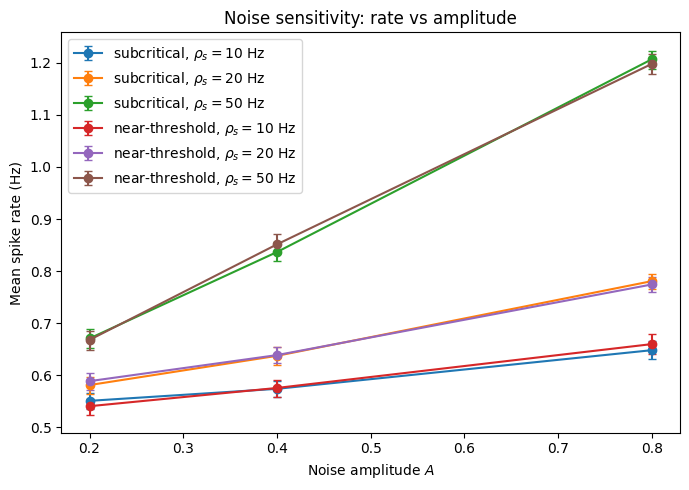

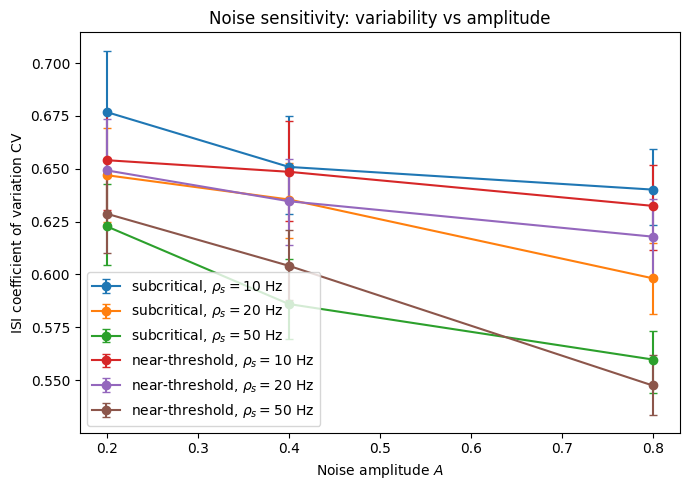

In [ ]:
# Rate vs A
plt.figure(figsize=(7,5))
for regime in ["subcritical","near-threshold"]:
    for rho in rho_list:
        d = df_sum[(df_sum["regime"]==regime) & (df_sum["rho_noise"]==rho)]
        x = d["A_noise"].values
        y = d["mean_rate"].values
        lo = d["mean_rate_CI_lo"].values
        hi = d["mean_rate_CI_hi"].values
        yerr = np.vstack([y - lo, hi - y])
        plt.errorbar(x, y, yerr=yerr, marker='o', capsize=3,
                     label=f"{regime}, $\\rho_s={rho:.0f}$ Hz")
plt.xlabel("Noise amplitude $A$")
plt.ylabel("Mean spike rate (Hz)")
plt.title("Noise sensitivity: rate vs amplitude")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "noise_rate_vs_A.png"), dpi=240)
plt.show()

plt.figure(figsize=(7,5))
for regime in ["subcritical","near-threshold"]:
    for rho in rho_list:
        d = df_sum[(df_sum["regime"]==regime) & (df_sum["rho_noise"]==rho)]
        x = d["A_noise"].values
        y = d["mean_CV"].values
        lo = d["mean_CV_CI_lo"].values
        hi = d["mean_CV_CI_hi"].values
        yerr = np.vstack([y - lo, hi - y])
        plt.errorbar(x, y, yerr=yerr, marker='o', capsize=3,
                     label=f"{regime}, $\\rho_s={rho:.0f}$ Hz")
plt.xlabel("Noise amplitude $A$")
plt.ylabel("ISI coefficient of variation $\\mathrm{CV}$")
plt.title("Noise sensitivity: variability vs amplitude")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, "noise_cv_vs_A.png"), dpi=240)
plt.show()